In [1]:
# !curl -o zen_dataset.tar.gz https://www.dropbox.com/s/5ugsinj434yzmu6/zen_dataset.tar.gz?dl=0
# !tar -xzvf zen_dataset.tar

In [2]:
# !pip install catboost

# Ranking model

Classical multistage recommendations pipeline looks like following:

![](
https://raw.githubusercontent.com/girafe-ai/recsys/3f374f49cede21d25c777aa3a274b9cbadc29d19/homeworks/recsys-pipeline.png)

1. Candidate selection: on this stage we use relative simple models (embeddings kNN, collaborative filtering result or SLIM)
1. Ranking model: candidates collected on previous stage are evaluated with more complex model (usually boosting nowadays).
1. Reranking: applying business logic, heuristics and ad-hocs.

We discussed this pipeline on the first lecture.

In this task you are to build dataset and train ranking model using Dzen dataset.

You need to use gradient boosting model e.g. Catboost (however any other goes well). As features you will need:
* Dot product, cosine distance between user and item embeddings. Models to use as embeddings source are:  *explicit* and *implicit ALS*, content models
* Item and user statistics (counters) such as CTR, view count, etc.


In [3]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp

from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score


import implicit

sns.set()

import torch
import os
import catboost
from transformers import AutoTokenizer, AutoModel

import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')
model = AutoModel.from_pretrained('cointegrated/rubert-tiny')

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly

In [4]:
item_counts = pd.read_csv('zen_dataset/item_counts.csv', index_col=0)
item_meta = pd.read_csv('zen_dataset/item_meta.gz', compression='gzip', index_col=0)
user_ratings = pd.read_csv('zen_dataset/user_ratings.gz', compression='gzip', index_col=0)

In [5]:
def encode_column_as_string(df, column):
    df[column] = df[column].apply(str)

def encode_and_transform(df, column, encoder):
    return np.array(encoder.transform(df[column]), dtype=np.int64)

def create_user_item_matrix(user_ratings, encoder, ratings_key, is_explicit=False):
    total_interactions_count = user_ratings[ratings_key].map(lambda x: x.values()).map(sum).sum() if is_explicit else user_ratings[ratings_key].map(len).sum()
    user_coo = [0] * total_interactions_count
    item_coo = [0] * total_interactions_count
    pos = 0

    for _, row in tqdm(user_ratings.iterrows()):
        item_ids = [k for k, v in row[ratings_key].items() if v == 1] if is_explicit else list(row[ratings_key].keys())
        user_id = row.userId
        for item in item_ids:
            user_coo[pos] = user_id
            item_coo[pos] = item
            pos += 1

    user_coo = encode_and_transform(pd.DataFrame({'userId': user_coo}), 'userId', user_encoder)
    item_coo = encode_and_transform(pd.DataFrame({'itemId': item_coo}), 'itemId', item_encoder)
    
    shape = (max(user_coo) + 1, max(item_coo) + 1)
    return sp.coo_matrix((np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape).tocsr()

encode_column_as_string(item_counts, 'itemId')
encode_column_as_string(item_meta, 'itemId')

user_encoder = LabelEncoder().fit(user_ratings['userId'])
item_encoder = LabelEncoder().fit(item_counts['itemId'])

user_ratings.trainRatings = user_ratings.trainRatings.map(eval)
user_ratings.testRatings = user_ratings.testRatings.map(eval)

implicit_user_item_matrix = create_user_item_matrix(user_ratings, item_encoder, 'trainRatings')
test_implicit_user_item_matrix = create_user_item_matrix(user_ratings, item_encoder, 'testRatings')
explicit_user_item_matrix = create_user_item_matrix(user_ratings, item_encoder, 'trainRatings', is_explicit=True)
test_explicit_user_item_matrix = create_user_item_matrix(user_ratings, item_encoder, 'testRatings', is_explicit=True)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
DIMENSION = 100

def get_predictions(X, Y, train_ratings, user):
    preds = X[user, :] @ Y.T
    user_train = train_ratings[user, :].toarray().flatten()
    preds[user_train != 0] = -1
    return preds


def mrr(X, Y, train_ratings, test_ratings):
    mrr = 0
    users = np.unique(test_ratings.tocoo().row)
    for user in tqdm(users):
        user_preds = get_predictions(X, Y, train_ratings, user)
        top_idxs = np.argsort(-user_preds)[:100]
        user_test = test_ratings[user].toarray().flatten()
        test_idx, *_ = np.arange(user_test.size)[user_test == 1]
        if test_idx in top_idxs:
            mrr += 1/(np.where(top_idxs == test_idx)[0][0] + 1)
    mrr = mrr / users.size
    return mrr

def calc_oposite_vectors_als(Y, A, k, lam):
    B = Y.T @ Y + lam * np.eye(k)
    C = A @ Y
    return (np.linalg.inv(B) @ C.T).T


def train_eals(data, dimension=DIMENSION, steps=10, lam: float=0.1):
    X, Y = np.random.rand(data.shape[0], dimension) * 0.01, np.random.rand(data.shape[1], dimension) * 0.01
    data = data.tocsr()
    for _ in tqdm(range(steps)):
        X = calc_oposite_vectors_als(Y, data, dimension, lam)
        Y = calc_oposite_vectors_als(X, data.T, dimension, lam)
    return X, Y


def train_ials(data, dimension=DIMENSION, steps=10, alpha=10):
    model = implicit.als.AlternatingLeastSquares(factors=dimension, iterations=steps, alpha=alpha)
    model.fit(data)
    return model.user_factors, model.item_factors

In [7]:
eals_user_embeddings, eals_item_embeddings = train_eals(explicit_user_item_matrix, dimension=DIMENSION)
ials_user_embeddings, ials_item_embeddings = train_ials(explicit_user_item_matrix, dimension=DIMENSION)


mrr_ials = mrr(ials_user_embeddings, ials_item_embeddings, explicit_user_item_matrix, test_explicit_user_item_matrix)
mrr_eals = mrr(eals_user_embeddings, eals_item_embeddings, explicit_user_item_matrix, test_explicit_user_item_matrix)

print(f"MRR for IALS model: {mrr_ials}")
print(f"MRR for EALS model: {mrr_eals}")


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/75470 [00:00<?, ?it/s]

  0%|          | 0/75470 [00:00<?, ?it/s]

MRR for IALS model: 0.007147233400993508
MRR for EALS model: 0.005732074520023937


In [24]:
import os

def save_embeddings(
    eals_user_embeddings: np.ndarray, 
    eals_item_embeddings: np.ndarray, 
    ials_user_embeddings: np.ndarray, 
    ials_item_embeddings: np.ndarray, 
    directory: str = "embeddings"
) -> None:
    if not os.path.exists(directory):
        os.makedirs(directory)

    np.save(os.path.join(directory, 'eals_user_embeddings.npy'), eals_user_embeddings)
    np.save(os.path.join(directory, 'eals_item_embeddings.npy'), eals_item_embeddings)
    np.save(os.path.join(directory, 'ials_user_embeddings.npy'), ials_user_embeddings)
    np.save(os.path.join(directory, 'ials_item_embeddings.npy'), ials_item_embeddings)

    print(f"Embeddings have been saved to the directory: {directory}")

save_embeddings(eals_user_embeddings, eals_item_embeddings, ials_user_embeddings, ials_item_embeddings)

Embeddings have been saved to the directory: embeddings


## Content model (5 points)

Choose content model you like and apply it to all the items (remember to use all available information).

Some sane choices are: RuBERT or any CLIP model. You may found them on [Hugging face](https://huggingface.co/models)

Which dimensionality to choose for content model? Why?

#### The more dimensionality the better, because we can encode more information into one embedding and therefore distinguish text better, but it may be computationaly expensive to calculate big embeddings. So for my working machine I decided to choose tiny model with 312 dimensional embeddings for better performance

In [8]:
from typing import List
import numpy as np
import torch
from transformers import PreTrainedModel, PreTrainedTokenizer
from tqdm import tqdm

def embed_bert_cls(text_batch: List[str], model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> np.ndarray:
    t = tokenizer(text_batch, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.cpu().numpy()

def create_content_embeddings(
    item_meta: pd.DataFrame,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    batch_size: int = 100
) -> np.ndarray:
    union_item_meta = item_meta.copy().fillna('')
    union_item_meta['content'] = union_item_meta['title'] + union_item_meta['content']
    union_item_meta = union_item_meta.drop(columns=['title'])
    
    contents = union_item_meta['content'].tolist()
    content_item_embeddings = []

    for i in tqdm(range(len(contents) // batch_size + 1)):
        batch = contents[i * batch_size: i * batch_size + batch_size]
        if batch:
            embeddings = embed_bert_cls(batch, model, tokenizer)
            content_item_embeddings.extend(embeddings)

    return np.array(content_item_embeddings)


In [9]:
batch_size = 200
content_item_embeddings = create_content_embeddings(item_meta, model, tokenizer, batch_size)

idxs = item_encoder.transform(item_meta['itemId'].tolist())
content_item_embeddings = content_item_embeddings[idxs]

100%|██████████| 523/523 [25:15<00:00,  2.90s/it]


## ALS step from content model (5 points)

To use content based information (important for cold items and users) in user-item ranking you need to build user embeddings. One simple way is to perform ALS step with item embeddings fixed to compute user embeddings.

Then you will use these embeddings to compute user-item features for final ranking.

In [10]:
_, dimension = content_item_embeddings.shape
lam = 0.1
content_user_embeddings = calc_oposite_vectors_als(content_item_embeddings, implicit_user_item_matrix, dimension, lam)

## Ranking (10 points)


Build embedding based user-item features for ranking model.

In [11]:
class EmbeddingFeatureGetter:
    def __init__(self, user_embeddings: np.ndarray, item_embeddings: np.ndarray):
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings

    def get_features(self, user_id: int, item_ids: List[int]) -> tuple[np.ndarray, np.ndarray]:
        user_vector = self.user_embeddings[user_id]
        item_vectors = self.item_embeddings[item_ids]

        dot_product = user_vector @ item_vectors.T
        cosine_similarity = dot_product / (np.linalg.norm(user_vector) * np.linalg.norm(item_vectors, axis=1))
        
        return dot_product, cosine_similarity


In [12]:
eals_features_getter = EmbeddingFeatureGetter(eals_user_embeddings, eals_item_embeddings)
ials_features_getter = EmbeddingFeatureGetter(ials_user_embeddings, ials_item_embeddings)
content_features_getter = EmbeddingFeatureGetter(content_user_embeddings, content_item_embeddings)

user_ratings['userId_encoded'] = user_encoder.transform(user_ratings.userId.values)

In [13]:
item_to_id = dict(zip(item_counts['itemId'], item_encoder.transform(item_counts['itemId'])))

In [14]:
def create_interaction_dataframe(user_ratings: pd.DataFrame, feature_getter: EmbeddingFeatureGetter, encoder: LabelEncoder) -> pd.DataFrame:
    rows = []
    for _, row in tqdm(user_ratings.iterrows(), total=len(user_ratings)):
        for item_id, rating in row.trainRatings.items():
            rows.append({'userId': row.userId_encoded, 'itemId': item_to_id[item_id], 'rating': rating})
        for item_id, rating in row.testRatings.items():
            rows.append({'userId': row.userId_encoded, 'itemId': item_to_id[item_id], 'rating': rating})
    return pd.DataFrame(rows)

In [15]:
train_df = create_interaction_dataframe(user_ratings, eals_features_getter, item_encoder)

100%|██████████| 75910/75910 [03:16<00:00, 386.48it/s]


In [16]:
test_df = create_interaction_dataframe(user_ratings, ials_features_getter, item_encoder)

100%|██████████| 75910/75910 [03:26<00:00, 368.25it/s]


In [17]:
def calculate_item_features(df: pd.DataFrame) -> pd.DataFrame:
    item_features = df.groupby('itemId')['rating'].agg([('clicks', 'sum'), ('shows', 'count')])
    item_features['ctr'] = (item_features['clicks'] / item_features['shows']) * 100
    item_features = item_features.drop(columns='clicks')
    return item_features

def calculate_user_features(df: pd.DataFrame) -> pd.DataFrame:
    user_features = df.groupby('userId')['rating'].agg([('total', 'count'), ('positive', 'sum')])
    user_features['positive_ratio'] = user_features['positive'] / user_features['total']
    user_features = user_features.drop(columns=['positive'])
    return user_features

item_features = calculate_item_features(train_df)
user_features = calculate_user_features(train_df)

train_df = train_df.merge(user_features, on='userId').merge(item_features, on='itemId')
test_df = test_df.merge(user_features, on='userId').merge(item_features, on='itemId')

In [18]:
def add_embedding_features(df: pd.DataFrame, features_getter: EmbeddingFeatureGetter) -> pd.DataFrame:
    rows = []
    grouped_df = df.groupby('userId')['itemId'].apply(list)
    
    for user_id, item_ids in tqdm(grouped_df.items(), total=len(grouped_df)):
        user_ids = [user_id] * len(item_ids)
        als_dot, als_cos = features_getter.get_features(user_id, item_ids)
        _zip = zip(als_dot, als_cos, item_ids, user_ids)
        rows.extend([(*t,) for t in _zip])
    
    interaction_features = pd.DataFrame(rows, columns=['als_dot', 'als_cos', 'itemId', 'userId'])
    return df.merge(interaction_features, on=['userId', 'itemId'])

train_df = add_embedding_features(train_df, eals_features_getter)
test_df = add_embedding_features(test_df, ials_features_getter)


  0%|          | 0/75910 [00:00<?, ?it/s]/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_79643/1352538764.py:17: RuntimeWarning: invalid value encountered in divide
  cosine_similarity = dot_product / (np.linalg.norm(user_vector) * np.linalg.norm(item_vectors, axis=1))
  0%|          | 0/75910 [00:00<?, ?it/s]/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_79643/1352538764.py:17: RuntimeWarning: invalid value encountered in divide
  cosine_similarity = dot_product / (np.linalg.norm(user_vector) * np.linalg.norm(item_vectors, axis=1))
100%|██████████| 75910/75910 [28:24<00:00, 44.53it/s] 


In [19]:
train_features = train_df.drop(columns=['userId', 'itemId', 'rating']).to_numpy()
train_labels = train_df['rating'].to_numpy()
train_group_ids = train_df['userId'].to_numpy(dtype=np.int64)
train_pool = catboost.Pool(train_features, train_labels, group_id=train_group_ids)

test_features = test_df.drop(columns=['userId', 'itemId', 'rating']).to_numpy()
test_labels = test_df['rating'].to_numpy()
test_group_ids = test_df['userId'].to_numpy(dtype=np.int64)
test_pool = catboost.Pool(test_features, test_labels, group_id=test_group_ids)

Train the model. For the best result you may need to read about [loss functions](https://catboost.ai/en/docs/references/training-parameters/common#loss_function) and their parameters.

Try two cases:
* binary classification
* ranking loss

In case of ranking pay attention to amount of pairs sampled as it can get training very long.


In [20]:
cb_classification = catboost.CatBoost({
    'loss_function': 'Logloss',
    'custom_metric': ['AUC', 'NDCG', 'MAP', 'PrecisionAt:top=100'],
    'depth': 5,
    'iterations': 100
})
cb_classification.fit(train_pool, eval_set=test_pool, logging_level='Verbose')

Learning rate set to 0.5
0:	learn: 0.4690032	test: 0.5214212	best: 0.5214212 (0)	total: 5.26s	remaining: 8m 40s
1:	learn: 0.3908845	test: 0.4543489	best: 0.4543489 (1)	total: 9.74s	remaining: 7m 57s
2:	learn: 0.3561850	test: 0.4152719	best: 0.4152719 (2)	total: 14.5s	remaining: 7m 48s
3:	learn: 0.3406510	test: 0.3885706	best: 0.3885706 (3)	total: 19.2s	remaining: 7m 41s
4:	learn: 0.3328115	test: 0.3769804	best: 0.3769804 (4)	total: 24s	remaining: 7m 35s
5:	learn: 0.3291549	test: 0.3781121	best: 0.3769804 (4)	total: 28.7s	remaining: 7m 29s
6:	learn: 0.3266139	test: 0.3751992	best: 0.3751992 (6)	total: 34s	remaining: 7m 31s
7:	learn: 0.3250748	test: 0.3756032	best: 0.3751992 (6)	total: 39s	remaining: 7m 29s
8:	learn: 0.3242211	test: 0.3744709	best: 0.3744709 (8)	total: 43.8s	remaining: 7m 23s
9:	learn: 0.3236475	test: 0.3742417	best: 0.3742417 (9)	total: 49.1s	remaining: 7m 21s
10:	learn: 0.3233645	test: 0.3670593	best: 0.3670593 (10)	total: 54.6s	remaining: 7m 22s
11:	learn: 0.3228921	t

In [22]:
cb_ranking = catboost.CatBoost({
    'loss_function': 'PairLogit:max_pairs=100',
    'custom_metric': ['AUC', 'NDCG', 'MAP', 'PrecisionAt:top=100'],
    'learning_rate': 0.1,
    'depth': 5,
    'iterations': 100
})
cb_ranking.fit(train_pool, eval_set=test_pool, logging_level='Verbose')

0:	learn: 0.6654811	test: 0.6641920	best: 0.6641920 (0)	total: 6s	remaining: 9m 53s
1:	learn: 0.6426474	test: 0.6404573	best: 0.6404573 (1)	total: 11.7s	remaining: 9m 34s
2:	learn: 0.6237621	test: 0.6205622	best: 0.6205622 (2)	total: 17.8s	remaining: 9m 34s
3:	learn: 0.6079173	test: 0.5994895	best: 0.5994895 (3)	total: 24s	remaining: 9m 35s
4:	learn: 0.5946560	test: 0.5830676	best: 0.5830676 (4)	total: 30.3s	remaining: 9m 35s
5:	learn: 0.5834910	test: 0.5716712	best: 0.5716712 (5)	total: 37.3s	remaining: 9m 43s
6:	learn: 0.5738708	test: 0.5619811	best: 0.5619811 (6)	total: 43.9s	remaining: 9m 43s
7:	learn: 0.5655101	test: 0.5540274	best: 0.5540274 (7)	total: 50.2s	remaining: 9m 37s
8:	learn: 0.5583440	test: 0.5439196	best: 0.5439196 (8)	total: 56.6s	remaining: 9m 32s
9:	learn: 0.5522681	test: 0.5381947	best: 0.5381947 (9)	total: 1m 3s	remaining: 9m 28s
10:	learn: 0.5468553	test: 0.5328165	best: 0.5328165 (10)	total: 1m 9s	remaining: 9m 23s
11:	learn: 0.5421826	test: 0.5271709	best: 0.5

In [23]:
cb_ranking_scores = cb_ranking.get_best_score()['validation']
cb_classification_scores = cb_classification.get_best_score()['validation']

print(f"Ranking Model Scores: {cb_ranking_scores}")
print(f"Classification Model Scores: {cb_classification_scores}")

per_user_predictions = cb_ranking.predict(test_pool, prediction_type='Probability')[:, 1]
res_df = test_df.assign(probs=per_user_predictions)
res_df['item_probs'] = res_df[['itemId', 'probs']].apply(lambda x: (int(x[0]), x[1]), axis=1)

recommendations_per_user = (res_df.groupby('userId')['item_probs']
                            .apply(list)
                            .apply(lambda x: sorted(x, key=lambda k: k[1], reverse=True))
                            .apply(lambda x: [t[0] for t in x[:10]]))


Ranking Model Scores: {'NDCG:type=Base': 0.7643097381632676, 'PrecisionAt:top=100': 0.3236988323771575, 'MAP': 0.37123661111969525, 'AUC': 0.774190062392689, 'PairLogit:max_pairs=100': 0.49033044754226995}
Classification Model Scores: {'NDCG:type=Base': 0.752922720555131, 'Logloss': 0.3577430295800322, 'PrecisionAt:top=100': 0.3139267338394154, 'MAP': 0.35465679035766157, 'AUC': 0.7965670241622163}


/var/folders/zt/_v1n_20j10g2dr5x0tx0xz200000gp/T/ipykernel_79643/847790377.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res_df['item_probs'] = res_df[['itemId', 'probs']].apply(lambda x: (int(x[0]), x[1]), axis=1)


## Analysis and conclusion (10 points)

Analyse feature importance using [shap values](https://github.com/shap/shap). Make some visualizations.

Make a conclusions on which loss works better in this case and how is it corellated with features and results (concrete rankings).

In [ ]:
test_df_features = test_df.drop(columns=['userId', 'itemId', 'rating'])

In [29]:
# OOM may occure
# saving files

import os

def save_test_df_features(test_df_features: pd.DataFrame, filename: str = "test_df_features.csv", directory: str = "embeddings") -> None:
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, filename)
    test_df_features.to_csv(filepath, index=False)

    print(f"test_df_features has been saved to: {filepath}")

save_test_df_features(test_df_features)

test_df_features has been saved to: embeddings/test_df_features.csv


In [30]:
def save_catboost_model(model: catboost.CatBoost, filename: str, directory: str = "models") -> None:
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, filename)
    
    model.save_model(filepath)
    
    print(f"Model has been saved to: {filepath}")

save_catboost_model(cb_ranking, "cb_ranking_model.cbm")
save_catboost_model(cb_classification, "cb_classification_model.cbm")

Model has been saved to: models/cb_ranking_model.cbm
Model has been saved to: models/cb_classification_model.cbm


In [31]:
import shap

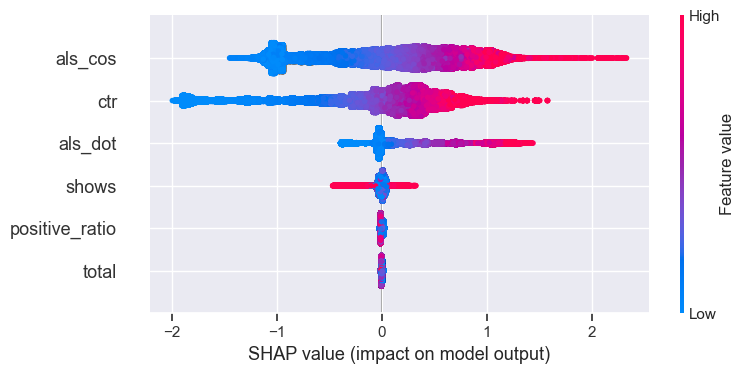

In [32]:
def analyze_shap_values(model: catboost.CatBoost, features: pd.DataFrame, max_samples: int) -> np.ndarray:
    if len(features) > max_samples:
        features = shap.sample(features, max_samples)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)
    shap.summary_plot(shap_values, features)
    return shap_values

shap_values_ranking = analyze_shap_values(cb_ranking, test_df_features, max_samples=int(len(test_df_features)/100)) # limit the number of samples to random 1%

### SHAP Values for Classification Model

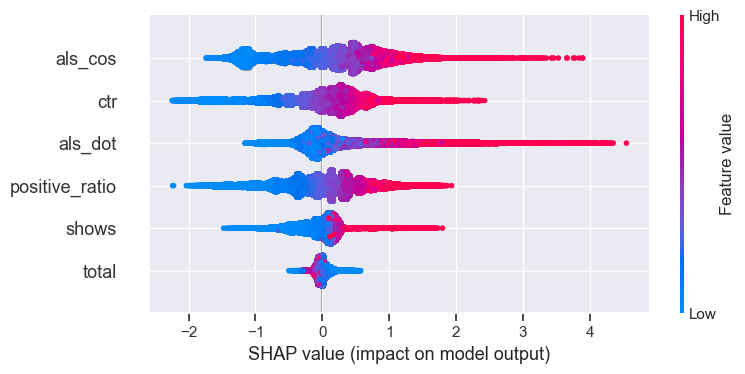

Ranking Model Validation Metrics: {'NDCG:type=Base': 0.7643097381632676, 'PrecisionAt:top=100': 0.3236988323771575, 'MAP': 0.37123661111969525, 'AUC': 0.774190062392689, 'PairLogit:max_pairs=100': 0.49033044754226995}
Classification Model Validation Metrics: {'NDCG:type=Base': 0.752922720555131, 'Logloss': 0.3577430295800322, 'PrecisionAt:top=100': 0.3139267338394154, 'MAP': 0.35465679035766157, 'AUC': 0.7965670241622163}


In [35]:
shap_values_classification = analyze_shap_values(cb_classification, test_df_features, max_samples=int(len(test_df_features)/100))

ranking_metrics = cb_ranking.get_best_score()['validation']
classification_metrics = cb_classification.get_best_score()['validation']

print(f"Ranking Model Validation Metrics: {ranking_metrics}")
print(f"Classification Model Validation Metrics: {classification_metrics}")

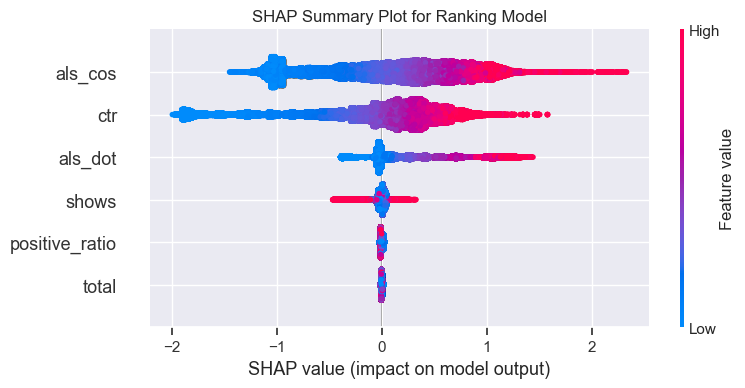

In [40]:
def analyze_shap_with_sampling(
    model: catboost.CatBoost, 
    features: pd.DataFrame, 
    max_samples: int = 1000, 
    title: str = "SHAP Summary Plot"
) -> None:
    if len(features) > max_samples:
        sampled_features = shap.sample(features, max_samples)
    else:
        sampled_features = features

    shap_values = shap.TreeExplainer(model).shap_values(sampled_features)
    
    shap.summary_plot(shap_values, sampled_features, show=False)
    plt.title(title)
    plt.show()
    
    del sampled_features

analyze_shap_with_sampling(cb_ranking, test_df_features, max_samples=int(len(test_df_features)/100), title="SHAP Summary Plot for Ranking Model")

In [41]:
cb_ranking.get_best_score()['validation']

{'NDCG:type=Base': 0.7643097381632676,
 'PrecisionAt:top=100': 0.3236988323771575,
 'MAP': 0.37123661111969525,
 'AUC': 0.774190062392689,
 'PairLogit:max_pairs=100': 0.49033044754226995}

In [42]:
cb_classification.get_best_score()['validation']

{'NDCG:type=Base': 0.752922720555131,
 'Logloss': 0.3577430295800322,
 'PrecisionAt:top=100': 0.3139267338394154,
 'MAP': 0.35465679035766157,
 'AUC': 0.7965670241622163}